# ABS Quarterly Wage Price Index 6345

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data-from-ABS" data-toc-modified-id="Get-data-from-ABS-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data from ABS</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot</a></span><ul class="toc-item"><li><span><a href="#Set-up-some-constants-we-will-use-across-all-plots" data-toc-modified-id="Set-up-some-constants-we-will-use-across-all-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Set-up some constants we will use across all plots</a></span></li><li><span><a href="#Remove-the-old-charts" data-toc-modified-id="Remove-the-old-charts-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Remove the old charts</a></span></li><li><span><a href="#Headline-WPI-for-Australia" data-toc-modified-id="Headline-WPI-for-Australia-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Headline WPI for Australia</a></span></li><li><span><a href="#WPI-Public-vs-Private" data-toc-modified-id="WPI-Public-vs-Private-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>WPI Public vs Private</a></span></li></ul></li><li><span><a href="#Finished" data-toc-modified-id="Finished-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Finished</a></span></li></ul></div>

## Python set-up

In [1]:
# system imports
import sys
import pathlib  
import re

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
from finalise_plot import finalise_plot
from abs_common import (
    get_fs_constants,
    get_plot_constants,
    get_ABS_meta_and_data,
    get_identifier,
    plot_growth2
)

# pandas display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# plotting stuff
plt.style.use('fivethirtyeight')

In [2]:
catalogue_id = '6345'
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

## Get data from ABS

In [3]:
# do the data capture and extraction to a DataFrame
abs_dict = get_ABS_meta_and_data(catalogue_id)
if abs_dict is None:
    sys.exit(-1)

Found URL for a ZIP file on ABS web page
Retrieving zip-file from cache ...
Extracting DataFrames from the zip-file ...


## Plot

### Set-up some constants we will use across all plots

In [4]:
meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)

### Remove the old charts

In [5]:
for filename in pathlib.Path(CHART_DIR).glob("*.png"):
    filename.unlink()

### Headline WPI for Australia

In [6]:
table = '1'
data = abs_dict[table]
print(data.index.freq)
series_type = 'Original'
select = 'Percentage Change from Corresponding Quarter of Previous Year'
selected = meta[
    (meta.Table == table)
    & (meta['Series Type'] == series_type)
    & meta['Data Item Description'].str.contains(select)
]

text = 'Total hourly rates of pay excluding bonuses ;  Australia'
count = 0
dict = {}
for start, plot_tag in zip(plot_times, plot_tags):
    for series_id, desc in zip(selected['Series ID'],
                               selected['Data Item Description']):
        
        # get the title
        title = desc.replace(select, '').replace(text, '').replace(';', '').strip()
        title = re.sub(' +', ' ', title)
    
        # get the data
        plot_data = data[series_id].dropna()
        plot_data = plot_data[plot_data.index >= pd.Period(start, freq=data.index.freq)] if start else plot_data
        
        # capture first two for comparative chart - public v private:
        if count < 2:
            dict[title] = plot_data
            count += 1

        # and plot
        ax = plot_data.plot(lw=2, color='#dd0000')
        finalise_plot(
            ax, f'Annual Wage Growth: {title}', 
            'Per cent per annum', plot_tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=text,
            #show=True,
        )        

<QuarterEnd: startingMonth=12>


### WPI Public vs Private

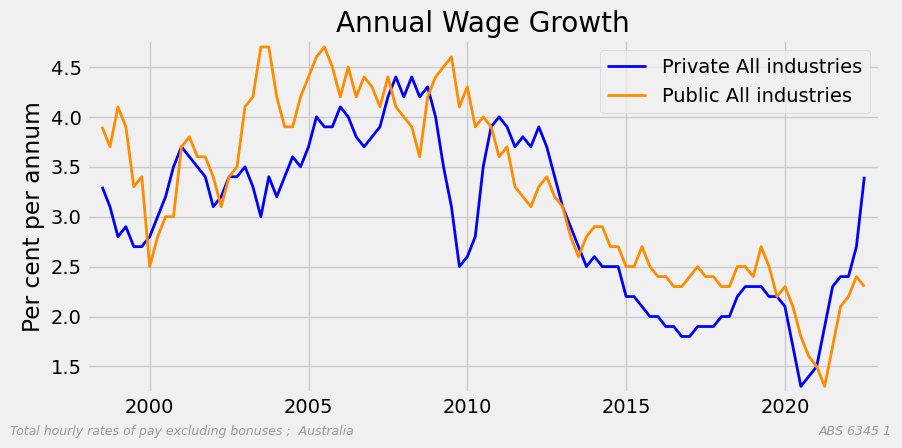

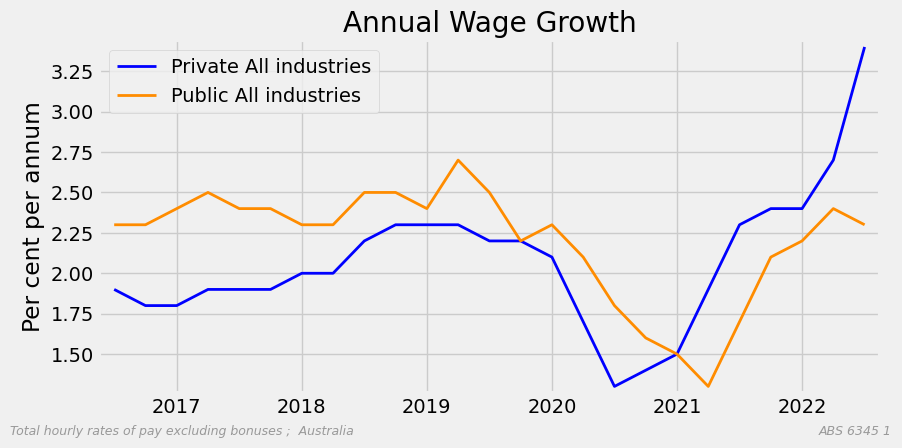

In [7]:
plot_data = pd.DataFrame(dict)
title = 'Annual Wage Growth'
for start, plot_tag in zip(plot_times, plot_tags):
    plot_data = plot_data[plot_data.index >= pd.Period(start, freq=data.index.freq)] if start else plot_data
    ax = plot_data.plot(lw=2, color=['blue', 'darkorange'])
    finalise_plot(
            ax, title, 
            'Per cent per annum', plot_tag, CHART_DIR,
            rfooter=f'{source} {table}',
            lfooter=text,
            show=True,
    )        

## Finished

In [8]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Mon Feb 06 2023 15:18:27

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.7.0

sys       : 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
re        : 2.2.1
numpy     : 1.24.1
pandas    : 1.5.3
matplotlib: 3.6.3

Watermark: 2.3.1



In [9]:
print('Finished')

Finished
